<a href="https://colab.research.google.com/github/ndb796/PyTorch-CNN/blob/main/PyTorch_CNN_Transfer_Learning_CIFAR10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **CIFAR10 Dataset**

* 작성자: 나동빈(Dongbin Na)
* 본 코드는 POSTECH의 **CSED703G 수업** 과제로 작성한 코드입니다.
* CNN을 이용해 CIFAR10 데이터셋에 대하여 학습/평가를 진행합니다.
* 코드 실행 전에 **[런타임]** → **[런타임 유형 변경]** → 유형을 **GPU**로 설정해야 합니다.

#### 필요한 라이브러리 불러오기

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import os

device = 'cuda'

#### 데이터셋(Dataset) 다운로드 및 불러오기

In [ ]:
import torchvision
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# 사전 학습된 모델의 경우 입력 데이터의 크기가 224 x 224이므로, CIFAR-10 데이터셋의 크기를 조절할 필요가 있음
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 좌우 반전 (MNIST 말고 CIFAR10에서는 효과적)
    transforms.ToTensor(),
    normalize, # 실험 결과, 입력 정규화(input normalization)가 성능에 크게 영향을 미치지는 않음
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


#### 학습(Training) 및 평가(Testing) 함수 정의

In [ ]:
def train(net, epoch, optimizer, criterion, train_loader):
    print('[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)


def evaluate(net, epoch, file_name, data_loader, info):
    print('[ Evaluate epoch: %d ]' % epoch)
    print("Dataset:", info)

    net.eval() # Dropout을 적용하는 경우 필수임
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        test_loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('Accuarcy:', 100. * correct / total)
    print('Average loss:', test_loss / total)
    return (100. * correct / total, test_loss / total)

#### 혼동행렬(Confusion Matrix) 함수 정의

* 학습이 완료된 모델을 불러와 혼동 행렬을 NumPy 객체로 반환합니다.
* 별도로 데이터 로더(data loader)를 파라미터로 이용해 해당 데이터셋에 대하여 평가를 진행합니다.

In [ ]:
def get_confusion_matrix(net, num_classes, data_loader):
    confusion_matrix = torch.zeros(num_classes, num_classes)

    net.eval() # Dropout을 적용하는 경우 필수임

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        _, predicted = outputs.max(1)

        for t, p in zip(targets.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

#### 결과 확인: ImageNet Pretrained ResNet18을 활용한 Transfer learning 결과 분석

In [ ]:
# 학습 과정 중에 천천히 학습률(learning rate) 감소 시키기
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 5:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

epoch = 10
learning_rate = 0.01
file_name = "Transfer_Learning_ResNet18_CIFAR10.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, train_loader, "Train"))
test_result.append(evaluate(net, 0, file_name, test_loader, "Test"))

for i in range(epoch):
    adjust_learning_rate(optimizer, epoch)
    train(net, i, optimizer, criterion, train_loader)
    train_acc, train_loss = evaluate(net, i + 1, file_name, train_loader, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, test_loader, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

[ Evaluate epoch: 0 ]
Dataset: Train
Accuarcy: 6.976
Average loss: 0.01981083899974823
[ Evaluate epoch: 0 ]
Dataset: Test
Accuarcy: 6.96
Average loss: 0.025350711703300475
[ Train epoch: 0 ]
Train accuarcy: 80.016
Train average loss: 0.005097268390059471
[ Evaluate epoch: 1 ]
Dataset: Train
Accuarcy: 91.79
Average loss: 0.0020763175159692763
[ Evaluate epoch: 1 ]
Dataset: Test
Accuarcy: 90.81
Average loss: 0.0029357786923646925
Model Saved!
[ Train epoch: 1 ]
Train accuarcy: 92.382
Train average loss: 0.0018199960163235664
[ Evaluate epoch: 2 ]
Dataset: Train
Accuarcy: 94.56
Average loss: 0.0013303456556797027
[ Evaluate epoch: 2 ]
Dataset: Test
Accuarcy: 92.89
Average loss: 0.0021218717500567437
Model Saved!
[ Train epoch: 2 ]
Train accuarcy: 94.444
Train average loss: 0.0013398012474179267
[ Evaluate epoch: 3 ]
Dataset: Train
Accuarcy: 95.988
Average loss: 0.001007140951305628
[ Evaluate epoch: 3 ]
Dataset: Test
Accuarcy: 93.66
Average loss: 0.0018473566673696041
Model Saved!
[ Trai

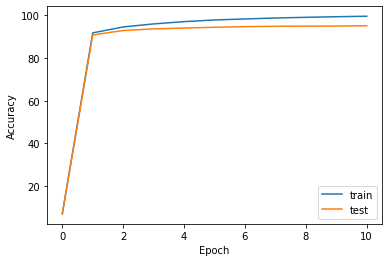

In [ ]:
# 정확도(accuracy) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[0] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()

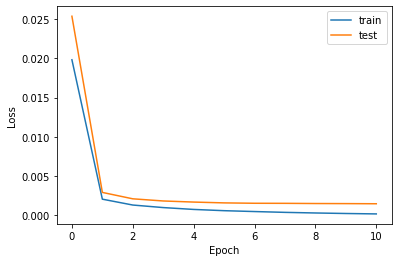

In [ ]:
# 손실(loss) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[1] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.])
[ 혼동 행렬(confusion matrix) 시각화 ]


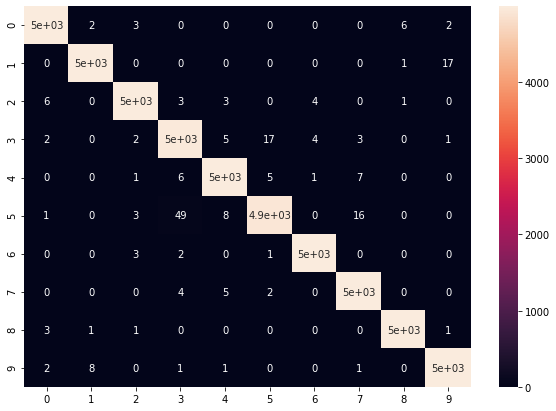

[ 각 클래스에 따른 정확도 ]
tensor([0.9974, 0.9964, 0.9966, 0.9932, 0.9960, 0.9846, 0.9988, 0.9978, 0.9988,
        0.9974])
[ 전체 평균 정확도 ]
tensor(0.9957)


In [ ]:
# 혼동 행렬(Confusion Matrix) 시각화 (학습 데이터셋)
net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_ResNet18_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, train_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

[ 각 클래스당 데이터 개수 ]
tensor([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.])
[ 혼동 행렬(confusion matrix) 시각화 ]


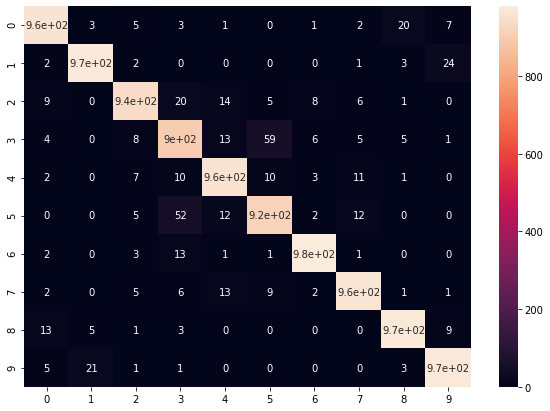

[ 각 클래스에 따른 정확도 ]
tensor([0.9580, 0.9680, 0.9370, 0.8990, 0.9560, 0.9170, 0.9790, 0.9610, 0.9690,
        0.9690])
[ 전체 평균 정확도 ]
tensor(0.9513)


In [ ]:
# 혼동 행렬(Confusion Matrix) 시각화 (테스트 데이터셋)
net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_ResNet18_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, test_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### 결과 확인: ImageNet Pretrained ResNet50을 활용한 Transfer learning 결과 분석

In [ ]:
# 학습 과정 중에 천천히 학습률(learning rate) 감소 시키기
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 5:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


net = torchvision.models.resnet50(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

epoch = 10
learning_rate = 0.01
file_name = "Transfer_Learning_ResNet50_CIFAR10.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, train_loader, "Train"))
test_result.append(evaluate(net, 0, file_name, test_loader, "Test"))

for i in range(epoch):
    adjust_learning_rate(optimizer, epoch)
    train(net, i, optimizer, criterion, train_loader)
    train_acc, train_loss = evaluate(net, i + 1, file_name, train_loader, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, test_loader, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

[ Evaluate epoch: 0 ]
Dataset: Train
Accuarcy: 10.104
Average loss: 0.036528523840904235
[ Evaluate epoch: 0 ]
Dataset: Test
Accuarcy: 10.51
Average loss: 0.036623323822021485
[ Train epoch: 0 ]
Train accuarcy: 87.866
Train average loss: 0.006186497809663415
[ Evaluate epoch: 1 ]
Dataset: Train
Accuarcy: 96.314
Average loss: 0.0018166531248018146
[ Evaluate epoch: 1 ]
Dataset: Test
Accuarcy: 94.51
Average loss: 0.0025022064216434956
Model Saved!
[ Train epoch: 1 ]
Train accuarcy: 95.878
Train average loss: 0.001966918377839029
[ Evaluate epoch: 2 ]
Dataset: Train
Accuarcy: 98.266
Average loss: 0.0009027730114106088
[ Evaluate epoch: 2 ]
Dataset: Test
Accuarcy: 95.74
Average loss: 0.0019508422621525824
Model Saved!
[ Train epoch: 2 ]
Train accuarcy: 97.642
Train average loss: 0.0011274123225733638
[ Evaluate epoch: 3 ]
Dataset: Train
Accuarcy: 98.99
Average loss: 0.0005657736237160861
[ Evaluate epoch: 3 ]
Dataset: Test
Accuarcy: 95.79
Average loss: 0.001946369522344321
Model Saved!
[ T

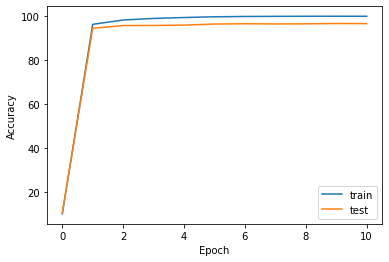

In [ ]:
# 정확도(accuracy) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[0] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()

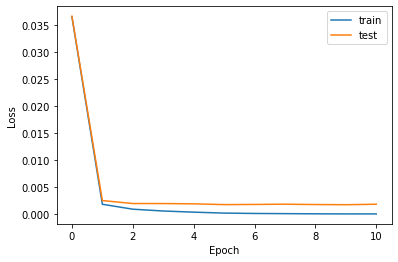

In [ ]:
# 손실(loss) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[1] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.])
[ 혼동 행렬(confusion matrix) 시각화 ]


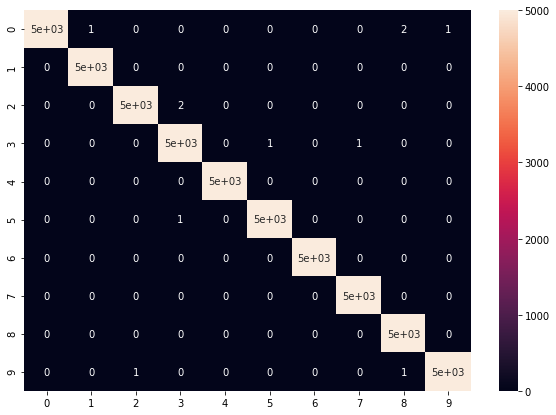

[ 각 클래스에 따른 정확도 ]
tensor([0.9992, 1.0000, 0.9996, 0.9996, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000,
        0.9996])
[ 전체 평균 정확도 ]
tensor(0.9998)


In [ ]:
# 혼동 행렬(Confusion Matrix) 시각화 (학습 데이터셋)
net = torchvision.models.resnet50(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_ResNet50_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, train_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

[ 각 클래스당 데이터 개수 ]
tensor([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.])
[ 혼동 행렬(confusion matrix) 시각화 ]


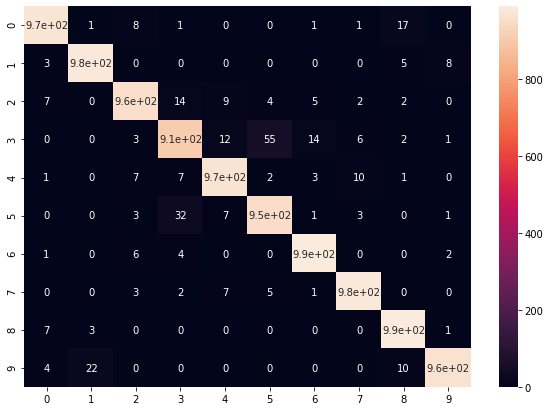

[ 각 클래스에 따른 정확도 ]
tensor([0.9710, 0.9840, 0.9570, 0.9070, 0.9690, 0.9530, 0.9870, 0.9820, 0.9890,
        0.9640])
[ 전체 평균 정확도 ]
tensor(0.9663)


In [ ]:
# 혼동 행렬(Confusion Matrix) 시각화 (테스트 데이터셋)
net = torchvision.models.resnet50(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_ResNet50_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, test_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### 결과 확인: ImageNet Pretrained ResNet101을 활용한 Transfer learning 결과 분석

In [ ]:
# 학습 과정 중에 천천히 학습률(learning rate) 감소 시키기
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 5:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


net = torchvision.models.resnet101(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

epoch = 10
learning_rate = 0.01
file_name = "Transfer_Learning_ResNet101_CIFAR10.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, train_loader, "Train"))
test_result.append(evaluate(net, 0, file_name, test_loader, "Test"))

for i in range(epoch):
    adjust_learning_rate(optimizer, epoch)
    train(net, i, optimizer, criterion, train_loader)
    train_acc, train_loss = evaluate(net, i + 1, file_name, train_loader, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, test_loader, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

In [ ]:
# 정확도(accuracy) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[0] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()

In [ ]:
# 손실(loss) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[1] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

In [ ]:
# 혼동 행렬(Confusion Matrix) 시각화 (학습 데이터셋)
net = torchvision.models.resnet101(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_ResNet101_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, train_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

In [ ]:
# 혼동 행렬(Confusion Matrix) 시각화 (테스트 데이터셋)
net = torchvision.models.resnet101(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_ResNet101_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, test_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

In [ ]:
from google.colab import files

In [ ]:
files.download('./checkpoint/Transfer_Learning_ResNet18_CIFAR10.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('./checkpoint/Transfer_Learning_ResNet50_CIFAR10.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('./checkpoint/Transfer_Learning_ResNet101_CIFAR10.pt')